### This notebook combines the two random samples

In [110]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord, match_coordinates_sky

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [112]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [113]:
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'

##### both `random_field1` and `random_field2` are 2deg * 2deg

In [92]:
PREFIX = 'random_field1'
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')

PREFIX = 'random_field2'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])

PREFIX = 'random_field3'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])
# lsbg_cat.sort('viz-id')
len(lsbg_cat)

2707

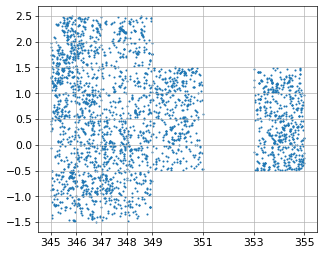

In [93]:
plt.scatter(lsbg_cat['ra'], lsbg_cat['dec'], s=2)
plt.grid()
plt.xticks([345, 346, 347, 348, 349, 351, 353, 355]);

In [94]:
total_area = 4 * 4 + 2 * 2 + 2 * 2
print('Total sky area [sqr deg]:', total_area)

Total sky area [sqr deg]: 24


Run `deploy_random.py` to run scarlet (both vanilla and spergel) on this sample.

---
### Analysis: make cuts to rule out junks

In [95]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='default', usetex=False)

In [96]:
method = 'vanilla'

PREFIX = 'random_field1'
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')

PREFIX = 'random_field2'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])

PREFIX = 'random_field3'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])
lsbg_cat.sort('viz-id')

meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_nosegmap_all.fits')
meas_cat.sort('ID')

seg_meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_segmap_all.fits')
seg_meas_cat.sort('ID')

assert np.sum(meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
assert np.sum(seg_meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'

In [97]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [98]:
from sample_cuts import make_cuts_vanilla, make_cuts_spergel, post_process_cat_new_rbf

# of Candy: 395
# of Gal: 1412
# of Junk: 900


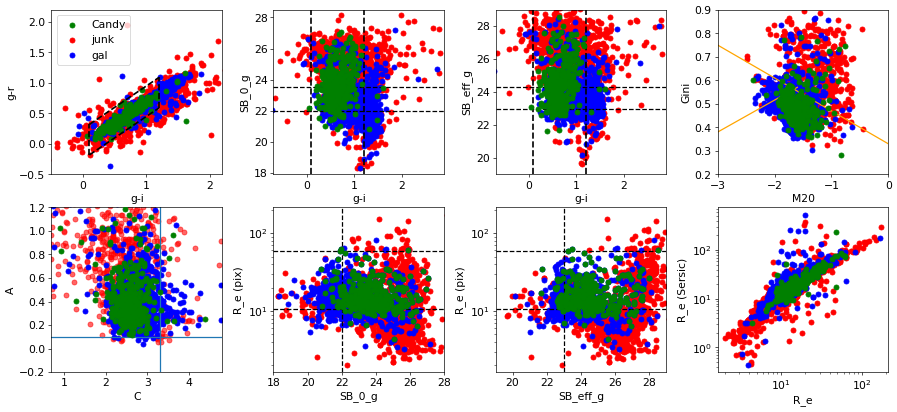

In [14]:
plot_measurement(lsbg_cat, meas_cat)

In [15]:
mask = make_cuts_vanilla(lsbg_cat, meas_cat)

Including morphological cuts
Candy: 223
Gal: 315
Junk: 22


# of Candy: 223
# of Gal: 315
# of Junk: 22


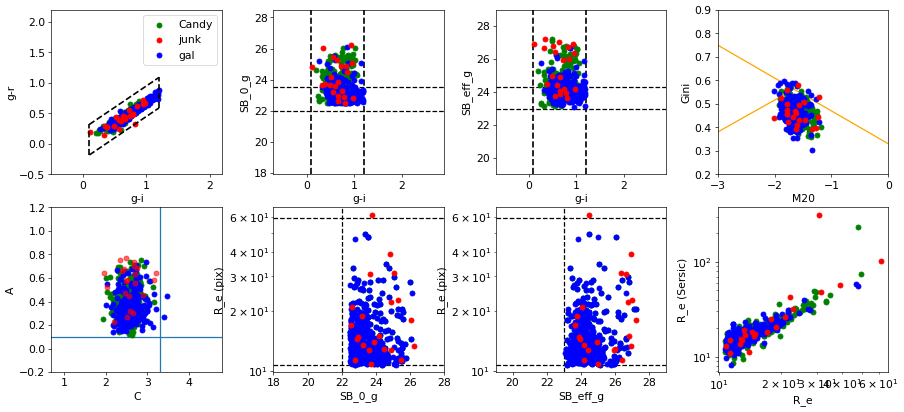

In [16]:
plot_measurement(lsbg_cat[mask], meas_cat[mask], gal_zorder=4, junk_zorder=5)

In [17]:
# Save this mask
np.save(f'./Catalog/random_field/lsbg_cuts_mask_{method}.npy', mask.data)

### Load Spergel catalog, apply mask, associate them with UDG hosts, apply UDG criteria

In [20]:
suffix = 'nosegmap'
method = 'spergel'

meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_{suffix}_all.fits')
meas_cat.sort('ID')
assert np.all(meas_cat['ID'] == lsbg_cat['viz-id']), "Two catalogs do not match!"
mask = np.load('./Catalog/random_field/lsbg_cuts_mask_vanilla.npy')

cuts_cat = hstack([lsbg_cat[mask], meas_cat[mask]])

# Additional step: remove large and small R_e in spergel
flag = make_cuts_spergel(cuts_cat)
cuts_cat = cuts_cat[flag]

print('Number of objs after junk cuts', len(cuts_cat))

Number of objs after junk cuts 517


In [21]:
### remove overlapping objects
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (3 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping pairs:')
else:
    print('No overlapping objects')

# because dist_mat is symmetric, we set the lower half to a random large number (i.e., 100)
dist_mat[np.triu_indices(len(dist_mat), 0)] = 100
inds = np.vstack(np.where((dist_mat < (3 * u.arcsec).to(u.deg).value)))
print(len(inds.T))

Have overlapping pairs:
10


In [22]:
re_diff = (cuts_cat[inds[0]]['rhalf_spergel'] - cuts_cat[inds[1]]['rhalf_spergel']) * 0.168
# write to vis inspection
from sample_cuts import match_two_arrays
ind1 = cuts_cat[inds[0][np.abs(re_diff) >= 2]]['viz-id'].data
ind2 = cuts_cat[inds[1][np.abs(re_diff) >= 2]]['viz-id'].data
ind = np.vstack([ind1, ind2]).T.ravel()
cuts_cat[match_two_arrays(cuts_cat['viz-id'].data, ind)][['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/random_fields/{name}_spergel_overlapping.txt', 
    format='ascii', overwrite=True)
# https://tigress-web.princeton.edu/~jiaxuanl/galary/
# after viz inspect, we find remove anyone is fine

In [23]:
to_remove_ind = list(cuts_cat[inds[0]]['viz-id'].data)
cuts_cat = cuts_cat[~np.in1d(cuts_cat['viz-id'], to_remove_ind)]
print('Number of objs after removing overlappers:', len(cuts_cat))

Number of objs after removing overlappers: 508


# of Candy: 213
# of Gal: 281
# of Junk: 14


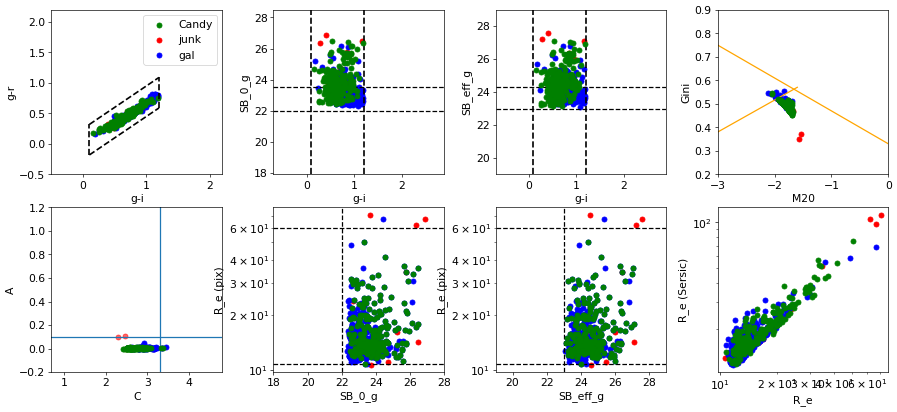

In [24]:
plot_measurement(cuts_cat, cuts_cat)#, gal_zorder=10)

In [21]:
cuts_cat.write(f'./Catalog/random_field/{name}/lsbg_after_cuts_spergel_{name}.fits', overwrite=True)

---
### Visual inspection

In [66]:
cuts_cat = Table.read(f'./Catalog/random_field/{name}/lsbg_after_cuts_spergel_{name}.fits')
len(cuts_cat)

508

In [72]:
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
## Remove real UDGs from random fields
udg_coor = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
cuts_coor = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
ind, sep, _ = match_coordinates_sky(cuts_coor, udg_coor)
print('Removed # of real MW-UDGs:', np.sum(sep < 1 * u.arcsec))
cuts_cat = cuts_cat[sep > 1 * u.arcsec]

Removed # of real MW-UDGs: 25


In [71]:
already_udg = cuts_cat[sep < 1 * u.arcsec]
bad_hosts = np.unique(udg_cat[ind[sep < 1 * u.arcsec]]['host_name'])

In [24]:
cuts_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/random_fields/{name}/lsbg_random_field_spergel_{name}_no_ovlp.txt', 
    format='ascii', overwrite=True)

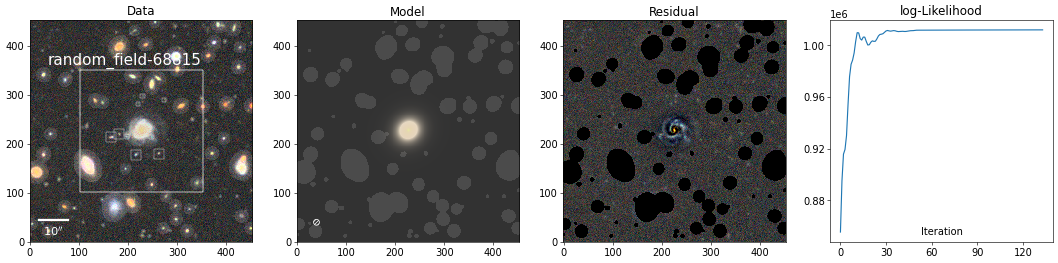

In [25]:
from PIL import Image
method = 'spergel'
Image.open(f'./Figure/random_field2/{method}/random_field-68815-zoomin-{method}.png')

In [73]:
votes = Table.read(f'{GALARY}/catalogs/random_fields/{name}/lsbg_random_field_spergel_{name}_votes.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')
cuts_cat = cuts_cat[flag]
len(cuts_cat)

483

In [76]:
cuts_cat = vstack([cuts_cat, already_udg])

In [77]:
junk = (cuts_cat['bad_votes'] > cuts_cat['good_votes'])
candy = (cuts_cat['good_votes'] > cuts_cat['bad_votes']) & (
    cuts_cat['is_candy'] > cuts_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 213
# of Gal: 281
# of Junk: 14


In [37]:
cuts_cat.write(
    f'{GALARY}/catalogs/random_fields/{name}/lsbg_random_field_spergel_after_viz.fits', 
              overwrite=True)
cuts_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/random_fields/{name}/lsbg_random_field_spergel_after_viz.txt', 
    format='ascii', overwrite=True)

---
### Random draws and select UDG sample

In [151]:
cuts_cat = Table.read(
    f'{GALARY}/catalogs/random_fields/{name}/lsbg_random_field_spergel_after_viz.fits')
len(cuts_cat)

483

In [144]:
# name = 'udg'
# udg_cat = Table.read(
#     f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
# flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
#        ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
# udg_cat = udg_cat[flag]
# udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

In [152]:
# input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
# from sample_cuts import post_process_cat_new_rbf
# udg_cat = post_process_cat_new_rbf(input_cuts_cat)

In [164]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))
print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))
lsbg_cat = lsbg_cat[np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]
print(len(lsbg_cat))
udg_cat = lsbg_cat
udg_cat['host_gi'] = np.zeros(len(udg_cat))

_, indx = np.unique(udg_cat['host_name'], return_index=True)
host_cat = udg_cat[indx]
print('Surveyed hosts:',len(host_cat))

Number of incomplete files: 65
Valid number of objects: 10579
10579
Surveyed hosts: 922


In [165]:
# udg_cat = udg_cat[~np.in1d(udg_cat['host_name'].data, bad_hosts)]

In [166]:
# from sample_cuts import post_process_cat_new_rbf

In [170]:
n_rep = 10
n_match = 20

UDG_num = []
for k in range(n_rep):
    # Randomly select lsbgs in the random fields
    inds = np.random.choice(np.arange(len(cuts_cat)), size=len(cuts_cat), replace=True)
    _cuts_cat = cuts_cat[inds]
    
    for i in range(n_match):
        # Randomly match with UDG hosts
        inds = np.random.randint(0, len(udg_cat), len(_cuts_cat))
        _temp = hstack([_cuts_cat, 
                        udg_cat[inds][[key for key in udg_cat.colnames if 'host' in key]]])
        _temp = post_process_cat_new_rbf(_temp)
    
        ### UDGs
        flag = (_temp['rhalf_phys'] + _temp['rhalf_phys_err'] >= 1.5
           ) & (_temp['SB_eff_avg'][:, 0] + _temp['SB_eff_avg_err'][:, 0] >= 25.0) # 24.5
        flag &= (_temp['completeness'] > 0.1)
        
        if i == 0 and k == 0:
            fake_udg_cat = _temp[flag]
        else:
            fake_udg_cat = vstack([fake_udg_cat, _temp[flag]])
        
        UDG_num.append(np.sum(flag))

print(np.mean(UDG_num) / len(_cuts_cat) * 100)

7.893374741200828


In [171]:
len(fake_udg_cat)

7625

In [172]:
np.mean(UDG_num) / 24, np.std(UDG_num) / 24

(1.5885416666666667, 0.2519347875002136)

In [175]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

Total angular area [deg2]: 89.19904707251214


In [176]:
np.mean(UDG_num) / 24 * total_area / 412, np.std(UDG_num) / 24 * total_area / 412

(0.3439233080137061, 0.054544521770473045)

In [48]:
print(np.std(UDG_num) / len(_cuts_cat) * 100)

1.6288141408145496


(array([ 420.,  179.,  200.,    0.,  409.,  111.,  808., 1205.,  936.,
        3901.]),
 array([0.23026974, 0.29926389, 0.36825803, 0.43725218, 0.50624632,
        0.57524047, 0.64423461, 0.71322876, 0.78222291, 0.85121705,
        0.9202112 ]),
 <BarContainer object of 10 artists>)

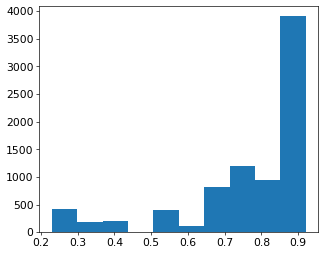

In [160]:
plt.hist(fake_udg_cat['completeness'])

In [177]:
fake_udg_cat.write(f'./Catalog/random_field/fake_{name}_cat_221025.fits', overwrite=True)
np.save(f'./Catalog/random_field/fake_{name}_cat_221025_{name}_num.npy', UDG_num)

## Size distribution

---

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

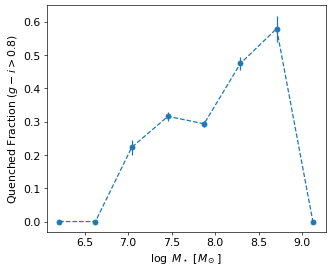

In [113]:
from scipy.stats import binned_statistic
red = ((fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]) > 0.8)
quench_frac, edges, _ = binned_statistic(fake_udg_cat['log_m_star'], red.astype(float), 
                                             statistic='mean', range=(6, 11), bins=12)
num, edges, _ = binned_statistic(fake_udg_cat['log_m_star'], red.astype(float), 
                                             statistic='count', range=(6, 11), bins=12)

plt.errorbar((edges[:-1] + edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [280]:
fake_udg_cat.write('./Catalog/random_test.fits')

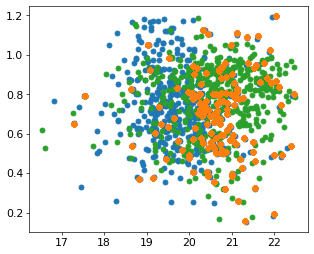

In [117]:
plt.scatter(cuts_cat['mag'][:, 1], (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]))

plt.scatter(fake_udg_cat['mag'][:, 1], (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['mag'][:, 1], (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

Text(0, 0.5, 'g-i')

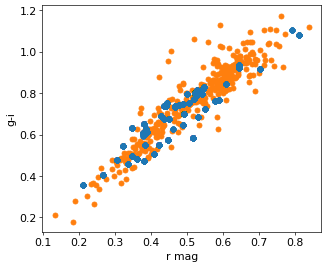

In [252]:
plt.scatter((fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 1]), 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]), 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('r mag')
plt.ylabel('g-i')

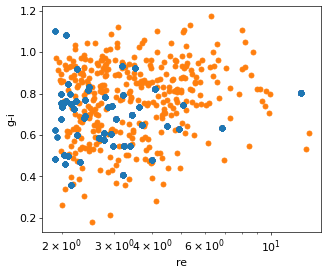

In [272]:
plt.scatter((fake_udg_cat['rhalf_spergel']), 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter((udg_cat['rhalf_spergel']), 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('re')
plt.ylabel('g-i')

plt.xscale('log')

Text(0, 0.5, 'g-i')

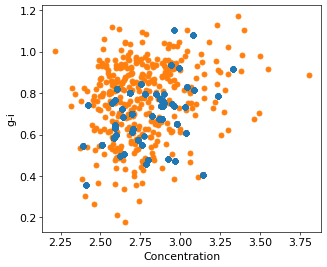

In [254]:
plt.scatter(fake_udg_cat['C'], 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['C'], 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('Concentration')
plt.ylabel('g-i')

In [ ]:
plt.scatter(fake_udg_cat['C'], 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['C'], 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('Concentration')
plt.ylabel('g-i')

In [101]:
np.mean(np.array(UDG_num) / 8)

4.10625

In [97]:
np.mean(np.array(UDG_num) / 8 * 27 / 352)

0.31496803977272725

In [98]:
np.array(UDG_num) / len(cuts_cat)

array([0.2137931 , 0.24137931, 0.2       , 0.20689655, 0.2137931 ,
       0.2137931 , 0.23448276, 0.24827586, 0.2137931 , 0.2       ,
       0.23448276, 0.22758621, 0.25517241, 0.25517241, 0.26206897,
       0.2137931 , 0.26206897, 0.17931034, 0.20689655, 0.24827586])

In [255]:
gi_color = fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]

(array([158., 229., 348., 621., 392., 809., 295., 108.,   0.,  44.]),
 array([0.35841065, 0.43304535, 0.50768005, 0.58231475, 0.65694945,
        0.73158415, 0.80621885, 0.88085355, 0.95548824, 1.03012294,
        1.10475764]),
 <BarContainer object of 10 artists>)

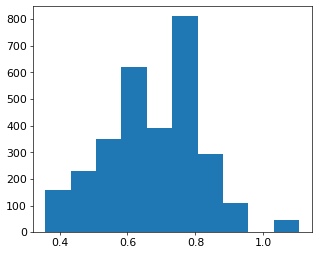

In [256]:
plt.hist(gi_color)

---

In [178]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))
print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))
lsbg_cat = lsbg_cat[np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]
print(len(lsbg_cat))

Number of incomplete files: 65
Valid number of objects: 10579
10579


In [183]:
#### Append host color
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in lsbg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

In [184]:
host_gi

array([1.38516515, 1.20304592, 0.92514262, ..., 0.93343571, 1.38516515,
       1.14808425])

In [186]:
lsbg_cat['host_gi'] = host_gi

In [187]:
lsbg_cat.write('./Catalog/nsa_z001_004/lsbg_before_cuts.fits', overwrite=True)